In [79]:
import torch
import matplotlib.pyplot as plt
import random

In [4]:
words = open("names.txt").read().split()

In [5]:
len(words)

32033

In [6]:
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [7]:
context_len = 3

X, Y = [], []

for w in words:
  context = [0] * context_len
  for ch in w + '.':
    X.append(context)
    Y.append(stoi[ch])
    context = context[1:] + [stoi[ch]]

X = torch.tensor(X)
Y = torch.tensor(Y)

print(f'X Shape: {X.shape}')
print(f'X data type: {X.dtype}')
print(f'Y Shape: {Y.shape}')
print(f'Y data type: {Y.dtype}')

X Shape: torch.Size([228146, 3])
X data type: torch.int64
Y Shape: torch.Size([228146])
Y data type: torch.int64


In [8]:
embeddings_matrix = torch.randn((27, 2))

In [9]:
embeddings = embeddings_matrix[X]
embeddings.shape

torch.Size([228146, 3, 2])

In [10]:
#Ways of flattening out
way1 = torch.cat((embeddings[:, 0, :], embeddings[:, 1, :], embeddings[:, 2, :]), dim=1)
print(f'Way1 Shape: {way1.shape}')
way2 = torch.cat(torch.unbind(embeddings, dim=1), dim=1)
print(f'Way2 Shape: {way2.shape}')
way3 = embeddings.reshape(embeddings.shape[0], -1)
print(f'Way3 Shape: {way3.shape}')
way4 = embeddings.view(embeddings.shape[0], -1)
print(f'Way4 Shape: {way4.shape}')

Way1 Shape: torch.Size([228146, 6])
Way2 Shape: torch.Size([228146, 6])
Way3 Shape: torch.Size([228146, 6])
Way4 Shape: torch.Size([228146, 6])


In [11]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [12]:
h = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [13]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [14]:
logits = h @ W2 + b2
probs = torch.softmax(logits, dim=1)

In [15]:
loss = -probs[torch.arange(len(Y)), Y].log().mean()
loss

tensor(12.8391)

In [16]:
loss = torch.nn.functional.cross_entropy(logits, Y)
loss

tensor(12.8391)

Cleaner Version and Overfitting a single batch

In [32]:
context_len = 3

X, Y = [], []

for w in words[:5]:
  context = [0] * context_len
  for ch in w + '.':
    X.append(context)
    Y.append(stoi[ch])
    context = context[1:] + [stoi[ch]]

X = torch.tensor(X)
Y = torch.tensor(Y)

print(f'X Shape: {X.shape}')
print(f'X data type: {X.dtype}')
print(f'Y Shape: {Y.shape}')
print(f'Y data type: {Y.dtype}')

X Shape: torch.Size([32, 3])
X data type: torch.int64
Y Shape: torch.Size([32])
Y data type: torch.int64


In [33]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
W2 = torch.randn((100, 27), generator=g)
b1 = torch.randn(100, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, W2, b1, b2]
for p in parameters:
  p.requires_grad = True

In [34]:
sum(p.nelement() for p in parameters)

3481

In [35]:
for i in range(100):
  #forward pass
  embeddings = C[X]
  h = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
  logits = h @ W2 + b2
  loss = torch.nn.functional.cross_entropy(logits, Y)

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  for p in parameters:
    p.data -= 0.1 * p.grad

  if (i+1) % 10 == 0:
    print(f'Epoch: {i+1}, Loss: {loss.item()}')

Epoch: 10, Loss: 5.177156925201416
Epoch: 20, Loss: 2.4692466259002686
Epoch: 30, Loss: 1.4052338600158691
Epoch: 40, Loss: 0.926850438117981
Epoch: 50, Loss: 0.6242833733558655
Epoch: 60, Loss: 0.42911842465400696
Epoch: 70, Loss: 0.3745386004447937
Epoch: 80, Loss: 0.3446305990219116
Epoch: 90, Loss: 0.32527709007263184
Epoch: 100, Loss: 0.31197431683540344


In [37]:
predictions = torch.max(logits, 1)
predictions

torch.return_types.max(
values=tensor([ 8.1731, 12.4352, 13.5064, 16.6895,  9.5250,  8.1731,  9.6540, 13.2942,
        14.3192, 14.3377, 12.2392, 12.3706,  8.1731,  9.7084, 10.2427,  9.7360,
         8.1731,  9.6486, 10.3808, 10.0958, 12.3948, 11.7369, 14.9610, 18.7677,
        11.9951,  8.1731,  8.4217, 12.4650, 14.5567, 16.4265, 16.4211,  9.9523],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0]))

In [38]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

Training a Full Dataset

In [43]:
context_len = 3

X, Y = [], []

for w in words:
  context = [0] * context_len
  for ch in w + '.':
    X.append(context)
    Y.append(stoi[ch])
    context = context[1:] + [stoi[ch]]

X = torch.tensor(X)
Y = torch.tensor(Y)

print(f'X Shape: {X.shape}')
print(f'X data type: {X.dtype}')
print(f'Y Shape: {Y.shape}')
print(f'Y data type: {Y.dtype}')

X Shape: torch.Size([228146, 3])
X data type: torch.int64
Y Shape: torch.Size([228146])
Y data type: torch.int64


In [61]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
W2 = torch.randn((100, 27), generator=g)
b1 = torch.randn(100, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, W2, b1, b2]
for p in parameters:
  p.requires_grad = True

In [45]:
sum(p.nelement() for p in parameters)

3481

In [46]:
for i in range(100):
  #forward pass
  embeddings = C[X]
  h = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
  logits = h @ W2 + b2
  loss = torch.nn.functional.cross_entropy(logits, Y)

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  for p in parameters:
    p.data -= 0.1 * p.grad

  if (i+1) % 10 == 0:
    print(f'Epoch: {i+1}, Loss: {loss.item()}')

Epoch: 10, Loss: 10.608251571655273
Epoch: 20, Loss: 7.5472283363342285
Epoch: 30, Loss: 6.001595973968506
Epoch: 40, Loss: 5.262874603271484
Epoch: 50, Loss: 4.8341898918151855
Epoch: 60, Loss: 4.532835006713867
Epoch: 70, Loss: 4.299739360809326
Epoch: 80, Loss: 4.110147953033447
Epoch: 90, Loss: 3.952338457107544
Epoch: 100, Loss: 3.817997932434082


Creating Mini Batches

In [60]:
for i in range(100):
  #forward pass
  ix = torch.randint(0, X.shape[0], (32, ))

  embeddings = C[X[ix]]
  h = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
  logits = h @ W2 + b2
  loss = torch.nn.functional.cross_entropy(logits, Y[ix])

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  for p in parameters:
    p.data -= 0.1 * p.grad

  if (i+1) % 10 == 0:
    print(f'Epoch: {i+1}, Loss: {loss.item()}')

Epoch: 10, Loss: 2.6255359649658203
Epoch: 20, Loss: 2.6385223865509033
Epoch: 30, Loss: 2.8649470806121826
Epoch: 40, Loss: 2.669961452484131
Epoch: 50, Loss: 2.4482388496398926
Epoch: 60, Loss: 2.8189070224761963
Epoch: 70, Loss: 3.110624074935913
Epoch: 80, Loss: 2.2957260608673096
Epoch: 90, Loss: 2.784839630126953
Epoch: 100, Loss: 3.0905237197875977


Finding good learning rate

In [68]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
W2 = torch.randn((100, 27), generator=g)
b1 = torch.randn(100, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, W2, b1, b2]
for p in parameters:
  p.requires_grad = True

In [69]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [70]:
lri = []
lossi = []

for i in range(1000):
  #forward pass
  ix = torch.randint(0, X.shape[0], (32, ))

  embeddings = C[X[ix]]
  h = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
  logits = h @ W2 + b2
  loss = torch.nn.functional.cross_entropy(logits, Y[ix])

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = lrs[i]
  for p in parameters:
    p.data -= lr * p.grad
  lri.append(lre[i])
  lossi.append(loss.item())

  # if (i+1) % 10 == 0:
  #   print(f'Epoch: {i+1}, Loss: {loss.item()}')

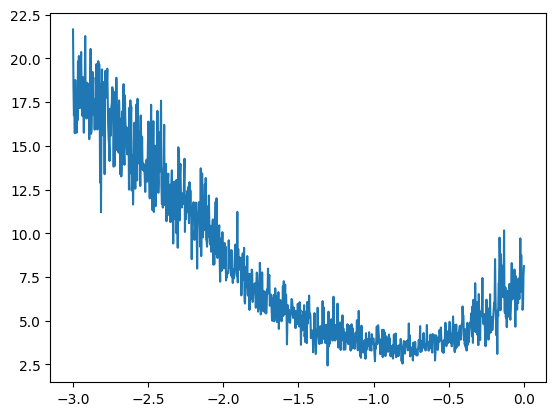

In [71]:
plt.plot(lri, lossi)

Training the model

In [74]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
W2 = torch.randn((100, 27), generator=g)
b1 = torch.randn(100, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, W2, b1, b2]
for p in parameters:
  p.requires_grad = True

In [75]:
#Initial Training with high learning rate
for i in range(30000):
  #forward pass
  ix = torch.randint(0, X.shape[0], (32, ))

  embeddings = C[X[ix]]
  h = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
  logits = h @ W2 + b2
  loss = torch.nn.functional.cross_entropy(logits, Y[ix])

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  for p in parameters:
    p.data -= 0.1 * p.grad

  if (i+1) % 3000 == 0:
    print(f'Epoch: {i+1}, Loss: {loss.item()}')

Epoch: 3000, Loss: 2.5809898376464844
Epoch: 6000, Loss: 2.583012819290161
Epoch: 9000, Loss: 2.4147322177886963
Epoch: 12000, Loss: 2.3849403858184814
Epoch: 15000, Loss: 2.249911069869995
Epoch: 18000, Loss: 2.4481823444366455
Epoch: 21000, Loss: 2.3643336296081543
Epoch: 24000, Loss: 2.590453624725342
Epoch: 27000, Loss: 2.1609609127044678
Epoch: 30000, Loss: 2.4497485160827637


In [76]:
#Fine Tuning with lower learning rate
for i in range(30000):
  #forward pass
  ix = torch.randint(0, X.shape[0], (32, ))

  embeddings = C[X[ix]]
  h = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
  logits = h @ W2 + b2
  loss = torch.nn.functional.cross_entropy(logits, Y[ix])

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  for p in parameters:
    p.data -= 0.01 * p.grad

  if (i+1) % 3000 == 0:
    print(f'Epoch: {i+1}, Loss: {loss.item()}')

Epoch: 3000, Loss: 2.174839735031128
Epoch: 6000, Loss: 2.5167999267578125
Epoch: 9000, Loss: 2.585805654525757
Epoch: 12000, Loss: 2.1893372535705566
Epoch: 15000, Loss: 1.8997230529785156
Epoch: 18000, Loss: 2.0581696033477783
Epoch: 21000, Loss: 2.225767135620117
Epoch: 24000, Loss: 2.625554323196411
Epoch: 27000, Loss: 2.216111898422241
Epoch: 30000, Loss: 2.2382266521453857


In [78]:
#Total Loss
embeddings = C[X]
h = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
loss = torch.nn.functional.cross_entropy(logits, Y)
loss

tensor(2.3168, grad_fn=<NllLossBackward0>)

Splitting the data into Train, Validation and Test

In [97]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
W2 = torch.randn((100, 27), generator=g)
b1 = torch.randn(100, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, W2, b1, b2]
for p in parameters:
  p.requires_grad = True

In [98]:
def build_dataset(words):
  context_len = 3

  X, Y = [], []

  for w in words:
    context = [0] * context_len
    for ch in w + '.':
      X.append(context)
      Y.append(stoi[ch])

      context = context[1:] + [stoi[ch]]

  X = torch.tensor(X)
  Y = torch.tensor(Y)

  return X, Y

In [99]:
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [100]:
#Initial Training with high learning rate
for i in range(30000):
  #forward pass
  ix = torch.randint(0, X_train.shape[0], (32, ))

  embeddings = C[X_train[ix]]
  h = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
  logits = h @ W2 + b2
  loss = torch.nn.functional.cross_entropy(logits, Y_train[ix])

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  for p in parameters:
    p.data -= 0.1 * p.grad

  if (i+1) % 3000 == 0:
    print(f'Epoch: {i+1}, Loss: {loss.item()}')

Epoch: 3000, Loss: 2.537693500518799
Epoch: 6000, Loss: 2.4881107807159424
Epoch: 9000, Loss: 2.3095428943634033
Epoch: 12000, Loss: 2.640951633453369
Epoch: 15000, Loss: 2.8165791034698486
Epoch: 18000, Loss: 1.9710931777954102
Epoch: 21000, Loss: 2.4275906085968018
Epoch: 24000, Loss: 2.2288527488708496
Epoch: 27000, Loss: 2.4204087257385254
Epoch: 30000, Loss: 2.282737970352173


In [101]:
#Fine Tuning with lower learning rate
for i in range(30000):
  #forward pass
  ix = torch.randint(0, X_train.shape[0], (32, ))

  embeddings = C[X_train[ix]]
  h = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
  logits = h @ W2 + b2
  loss = torch.nn.functional.cross_entropy(logits, Y_train[ix])

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  for p in parameters:
    p.data -= 0.01 * p.grad

  if (i+1) % 3000 == 0:
    print(f'Epoch: {i+1}, Loss: {loss.item()}')

Epoch: 3000, Loss: 2.2581732273101807
Epoch: 6000, Loss: 2.2008581161499023
Epoch: 9000, Loss: 2.5060501098632812
Epoch: 12000, Loss: 2.2483832836151123
Epoch: 15000, Loss: 2.37150502204895
Epoch: 18000, Loss: 1.9185672998428345
Epoch: 21000, Loss: 2.4129936695098877
Epoch: 24000, Loss: 2.1414387226104736
Epoch: 27000, Loss: 2.2935128211975098
Epoch: 30000, Loss: 2.1851015090942383


In [103]:
#Loss on entire train set
#Loss on val set
embeddings = C[X_train]
h = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
loss = torch.nn.functional.cross_entropy(logits, Y_train)
print(f'Validataion Loss: {loss.item()}')

Validataion Loss: 2.3261797428131104


In [105]:
#Loss on val set
embeddings = C[X_val]
h = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
loss = torch.nn.functional.cross_entropy(logits, Y_val)
print(f'Validataion Loss: {loss.item()}')

# Model is under-fitting as training and validataion loss are almost equal

Validataion Loss: 2.322852849960327


Visualising the embeddings

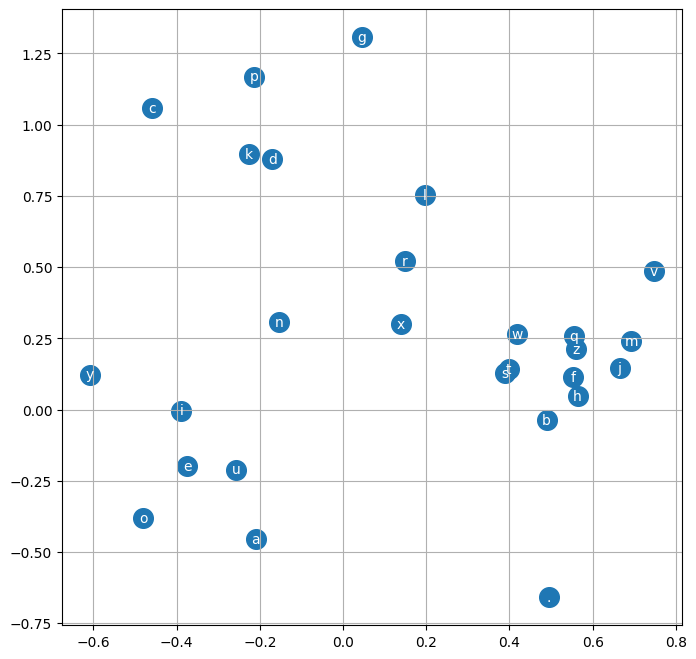

In [107]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Sampling from Model

In [114]:
names = []

for _ in range(10):
  context = [0] * context_len
  name = ''
  while True:
    embeddings = C[torch.tensor([context])]
    h = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = torch.nn.functional.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
    if ix == 0:
      break
    context = context[1:] + [ix]
    name += itos[ix]
  names.append(name)

names

['kan',
 'ken',
 'avantahn',
 'gisteaesan',
 'pelenseleoden',
 'eilyn',
 'ron',
 'lyy',
 'ryah',
 'len']